In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.models import Sequential
from keras.layers import Input, Conv3D, Flatten, Dense, MaxPooling3D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence

from config import *
from utils import specificity
from utils import sensitivity

In [ ]:
# Start timing
start_time = time.time()

In [4]:
# Tensorflow settings
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session, get_session

config = tf.ConfigProto()
config.gpu_options.visible_device_list = "7"
sess = tf.Session(config=config)
set_session(sess)

In [5]:
dtype = np.float32
result_dir = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/"

In [6]:
!mkdir -p $result_dir

In [7]:
# load hdf5 files and extract columns
train_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/train_2yr_and_unique_screening-921_subjects-96_114_96_shape-masked.h5", 'r')
holdout_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/test_2yr_and_unique_screening-150_subjects-96_114_96_shape-masked.h5", 'r')

X_train, y_train, files_train = train_h5['X'], train_h5['y'], train_h5["files"]
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [8]:
# convert data to numpy arrays
X_train = np.expand_dims(np.array(X_train, dtype=dtype), 4)
y_train = np.array(y_train)

X_holdout = np.expand_dims(np.array(X_holdout, dtype=dtype), 4)
y_holdout = np.array(y_holdout)

In [9]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of AD patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 921
Number of healthy controls: 464
Number of AD patients: 457


In [10]:
class ADNIDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [11]:
# images are already masked
mask = None

# Model

In [12]:
def SixtyFourNet(input_shape, drop_rate=0., weight_dcay=0.):
    model = Sequential()
    model.add(Conv3D(64, kernel_size=3, 
                     input_shape=(input_shape[1], input_shape[2], input_shape[3], 1), 
                     activation='elu', padding='valid', name='Conv_1'))
    model.add(MaxPooling3D(pool_size=3, name='Pool_1'))
    model.add(Dropout(drop_rate))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_2'))

    model.add(MaxPooling3D(pool_size=3, name='Pool_2'))
    model.add(Dropout(drop_rate))

    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_3',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_4',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(MaxPooling3D(pool_size=3, name='Pool_4'))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Normalization

In [13]:
files_train = np.array(files_train)

In [14]:
names_train = [item[53:53+10].decode('utf-8') for item in files_train]

### Normalize min-max

In [15]:
for i in range(len(X_train)):
    X_train[i] -= np.min(X_train[i])
    X_train[i] /= np.max(X_train[i])
    
for i in range(len(X_holdout)):
    X_holdout[i] -= np.min(X_holdout[i])
    X_holdout[i] /= np.max(X_holdout[i])

### Normalize by voxel and split data

In [16]:
GSS = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=22)
indices = list(GSS.split(names_train, groups=names_train))[0]
train_idx, val_idx = indices[0], indices[1]

mean = np.mean(X_train[train_idx], axis=0)
std = np.std(X_train[train_idx], axis=0)
X_train = (X_train - mean) / (std)

In [17]:
# shuffle indices test
np.random.shuffle(train_idx)
np.random.shuffle(val_idx)

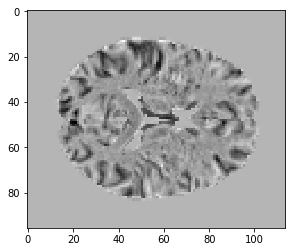

In [18]:
plt.imshow(X_train[4][:,:,46,0], cmap='gray')
plt.show()

(array([  2.,   5.,  13.,  19.,  42.,  71., 133., 317., 288.,  31.]),
 array([-5.081064  , -4.3799    , -3.6787355 , -2.977571  , -2.2764065 ,
        -1.5752423 , -0.8740778 , -0.17291342,  0.528251  ,  1.2294154 ,
         1.9305798 ], dtype=float32),
 <a list of 10 Patch objects>)

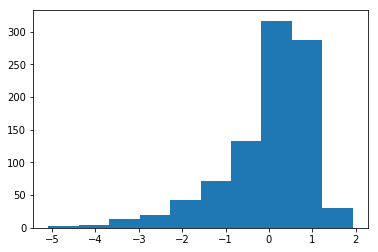

In [ ]:
plt.hist(X_train[:,40,71,40,0].flatten())

In [ ]:
X_train[4][:,:,46, 0]

array([[1.3599842, 1.3599842, 1.3599842, ..., 1.3599842, 1.3599842,
        1.3599842],
       [1.3599842, 1.3599842, 1.3599842, ..., 1.3599842, 1.3599842,
        1.3599842],
       [1.3599842, 1.3599842, 1.3599842, ..., 1.3599842, 1.3599842,
        1.3599842],
       ...,
       [1.3599842, 1.3599842, 1.3599842, ..., 1.3599842, 1.3599842,
        1.3599842],
       [1.3599842, 1.3599842, 1.3599842, ..., 1.3599842, 1.3599842,
        1.3599842],
       [1.3599842, 1.3599842, 1.3599842, ..., 1.3599842, 1.3599842,
        1.3599842]], dtype=float32)

# Training

Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 37s 46ms/step - loss: 3.4665 - acc: 0.5186 - val_loss: 1.7074 - val_acc: 0.5487
Epoch 2/45
808/808 [==============================] - 35s 44ms/step - loss: 1.2723 - acc: 0.5322 - val_loss: 0.8836 - val_acc: 0.7168
Epoch 3/45
808/808 [==============================] - 35s 43ms/step - loss: 0.8929 - acc: 0.5693 - val_loss: 1.1688 - val_acc: 0.4248
Epoch 4/45
808/808 [==============================] - 35s 43ms/step - loss: 1.1174 - acc: 0.5594 - val_loss: 0.8326 - val_acc: 0.7080
Epoch 5/45
808/808 [==============================] - 35s 44ms/step - loss: 0.7833 - acc: 0.6374 - val_loss: 0.7307 - val_acc: 0.7257
Epoch 6/45
808/808 [==============================] - 36s 44ms/step - loss: 0.7815 - acc: 0.6770 - val_loss: 0.7792 - val_acc: 0.7876
Epoch 7/45
808/808 [==============================] - 35s 44ms/step - loss: 1.3208 - acc: 0.6002 - val_loss: 1.1329 - val_acc: 0.6814
Epoch 8/45
808/8

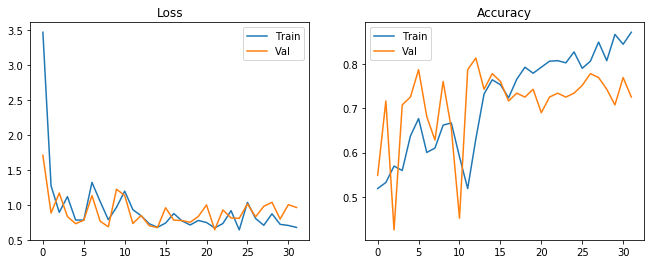

Final epoch results:
Balanced Accuracy: 74.13 %
Sensitivity: 58.06 %
Specificity: 90.20 %
Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 35s 44ms/step - loss: 3.4834 - acc: 0.5000 - val_loss: 1.3873 - val_acc: 0.5664
Epoch 2/45
808/808 [==============================] - 35s 43ms/step - loss: 4.4095 - acc: 0.5124 - val_loss: 5.0048 - val_acc: 0.5398
Epoch 3/45
808/808 [==============================] - 35s 43ms/step - loss: 4.9001 - acc: 0.5161 - val_loss: 4.0660 - val_acc: 0.4779
Epoch 4/45
808/808 [==============================] - 35s 44ms/step - loss: 1.7850 - acc: 0.4901 - val_loss: 1.1510 - val_acc: 0.4513
Epoch 5/45
808/808 [==============================] - 35s 43ms/step - loss: 1.0143 - acc: 0.5062 - val_loss: 0.8774 - val_acc: 0.4513
Epoch 6/45
808/808 [==============================] - 35s 43ms/step - loss: 1.0424 - acc: 0.5235 - val_loss: 0.9179 - val_acc: 0.5487
Epoch 7/45
808/808 [==============================] - 35s 43

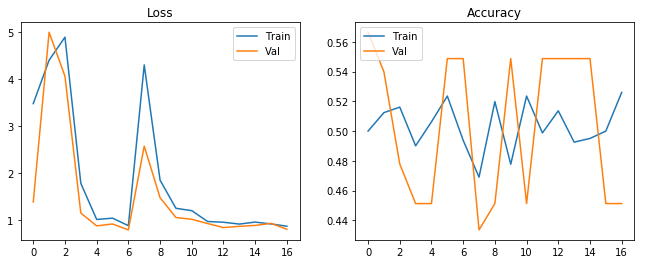

Final epoch results:
Balanced Accuracy: 50.00 %
Sensitivity: 0.00 %
Specificity: 100.00 %
Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 36s 44ms/step - loss: 3.7464 - acc: 0.5149 - val_loss: 1.6941 - val_acc: 0.4513
Epoch 2/45
808/808 [==============================] - 35s 43ms/step - loss: 1.2892 - acc: 0.5099 - val_loss: 0.9788 - val_acc: 0.6106
Epoch 3/45
808/808 [==============================] - 35s 43ms/step - loss: 2.3642 - acc: 0.4777 - val_loss: 4.8350 - val_acc: 0.5752
Epoch 4/45
808/808 [==============================] - 35s 43ms/step - loss: 3.1604 - acc: 0.4938 - val_loss: 1.5005 - val_acc: 0.5487
Epoch 5/45
808/808 [==============================] - 35s 44ms/step - loss: 1.2564 - acc: 0.5037 - val_loss: 1.0184 - val_acc: 0.5487
Epoch 6/45
808/808 [==============================] - 35s 43ms/step - loss: 1.0263 - acc: 0.4950 - val_loss: 1.1116 - val_acc: 0.4513
Epoch 7/45
808/808 [==============================] - 35s 43

In [ ]:
# training args
lr = 0.002
lr_decay = 0.

num_trials = 10
patience = 10
store_models = True

best_epoch_acc = []
final_epoch_sens = []
final_epoch_spec = []

for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.04, input_shape=X_train.shape)
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model_trial_%i.h5" %i), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    # Start training
    history = model.fit(
        X_train[train_idx],
        y_train[train_idx],
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_train[val_idx],y_train[val_idx]),
        callbacks=callbacks,
        shuffle=True
    )
    training_time = time.time() - start_time
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()    
    # Evaluation
    y_pred = model.predict(X_train[val_idx], batch_size=1).flatten() # predict and turn into 1-dimensional array
    sens = sensitivity(y_train[val_idx], y_pred>0.5)
    spec = specificity(y_train[val_idx], y_pred>0.5)
    # Store results
    best_epoch = np.argmax(history.history["val_acc"])
    best_epoch_acc.append(history.history["val_acc"][best_epoch])
    final_epoch_sens.append(sens)
    final_epoch_spec.append(spec)
    # Print results
    print("Final epoch results:")
    print("Balanced Accuracy: {:.2f} %".format(((sens + spec) * 100) / 2))
    print("Sensitivity: {:.2f} %".format(sens * 100))
    print("Specificity: {:.2f} %".format(spec * 100))

In [ ]:
print("All best val accuracies: {}".format(best_epoch_acc))
print("Average best validation accuracy over {} trials: {:.5f} (std: {:.5f})".format(num_trials, np.mean(best_epoch_acc), np.std(best_epoch_acc)))

In [ ]:
print("Final epochs sensitivity: {}".format(final_epoch_sens))
print("Final epochs specificity: {}".format(final_epoch_spec))

In [ ]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))

In [ ]:
np.max(history.history["val_acc"])

In [ ]:
quit()